<a href="https://colab.research.google.com/github/LenaVolzhina/playing-with-neural-networks/blob/master/DL_chapter_8_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задача

Научим генератор сэмплировать нормальное распределение из равномерного шума.

Линейным преобразованием это не сделать, так что нужно хотя бы два слоя

При этом дискриминатор должен быть выразительно более мощным, иначе он не сможет достичь оптимума и улучшить генератор


In [1]:
import numpy as np
import tensorflow as tf


gen_weights = dict()
gen_weights['w1'] = tf.Variable(tf.random_normal([1, 5]))
gen_weights['b1'] = tf.Variable(tf.random_normal([5]))
gen_weights['w2'] = tf.Variable(tf.random_normal([5, 1]))
gen_weights['b2'] = tf.Variable(tf.random_normal([1]))

disc_weights = dict()
disc_weights['w1'] = tf.Variable(tf.random_normal([1, 10]))
disc_weights['b1'] = tf.Variable(tf.random_normal([10]))
disc_weights['w2'] = tf.Variable(tf.random_normal([10, 10]))
disc_weights['b2'] = tf.Variable(tf.random_normal([10]))
disc_weights['w3'] = tf.Variable(tf.random_normal([10, 1]))
disc_weights['b3'] = tf.Variable(tf.random_normal([1]))

In [0]:
# заглушка для входного шума
z_p = tf.placeholder('float', [None, 1])

# заглушка для реальных данных
x_d = tf.placeholder('float', [None, 1])

# генератор
g_h = tf.nn.softplus(
  tf.add(
    tf.matmul(z_p, gen_weights['w1']),
    gen_weights['b1']
  )
)
x_g = tf.add(
    tf.matmul(g_h, gen_weights['w2']), 
    gen_weights['b2']
)    # без функции активации, т.к. они ограничены, а N нет

In [0]:
# дискриминатор
def discriminator(x):
  d_h1 = tf.nn.tanh(
    tf.add(
      tf.matmul(x, disc_weights['w1']),
      disc_weights['b1'])
    )
  d_h2 = tf.nn.tanh(
    tf.add(
      tf.matmul(d_h1, disc_weights['w2']), 
      disc_weights['b2']
    )
  )
  # сигмоида, чтобы интерпретировать выход как вероятность
  score = tf.nn.sigmoid(
    tf.add(
      tf.matmul(d_h2, disc_weights['w3']),
      disc_weights['b3']
    )
  )
  return score

# применяем к разным типам данных
x_data_score = discriminator(x_d)
x_gen_score = discriminator(x_g)

In [0]:
# функции потерь
D_cost = -tf.reduce_mean(
  tf.log(x_data_score) + tf.log(1.0 - x_gen_score)
)
G_cost = tf.reduce_mean(
  tf.log(1.0 - x_gen_score)
)

In [0]:
batch_size = 64
updates = 40000
learning_rate = 0.01

In [0]:
# оптимизаторы (к минимуму)
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
D_optimizer = optimizer.minimize(D_cost, var_list=disc_weights.values())
G_optimizer = optimizer.minimize(G_cost, var_list=gen_weights.values())

In [0]:
# распределения

# на вход равномерное на [-5, 5]
noise_range = 5
# генерируем N(-2.5, 5)
prior_mu = -2.5
prior_std = 0.5

def sample_z(size=batch_size):
  return np.random.uniform(-noise_range, noise_range, size=[size, 1])

def sample_x(size=batch_size, mu=prior_mu, std=prior_std):
  return np.random.normal(mu, std, size=[size, 1])

In [0]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [0]:
from datetime import datetime

for i in range(updates):
  z_batch = sample_z()
  x_batch = sample_x()
  sess.run(D_optimizer, feed_dict={z_p: z_batch, x_d: x_batch})
  z_batch = sample_z()
  sess.run(G_optimizer, feed_dict={z_p: z_batch})

# Визуализация

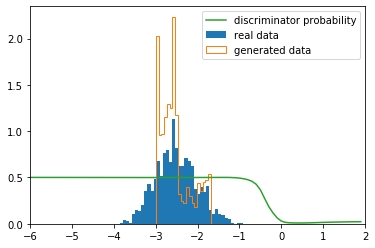

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def show_histograms(title=''):
  npoints = 1000

  # real data
  x_batch = sample_x(npoints)

  # noise
  z_batch = sample_z(npoints)

  # generator results
  g_batch = sess.run(x_g, feed_dict={z_p: z_batch})

  # discriminator results on real data range
  x_range = np.arange(-6, 2, 0.1).reshape(-1, 1)
  d_batch = sess.run(x_data_score, feed_dict={x_d: x_range})

  # print(x_batch.shape, z_batch.shape, g_batch.shape, d_batch.shape)

  # plot
  plt.figure()
  bins = int(npoints / 25)
  
  plt.hist(x_batch, label='real data', bins=bins, density=True)
  plt.hist(g_batch, histtype='step', label='generated data', bins=bins // 2, density=True)
  plt.plot(x_range, d_batch, label='discriminator probability')

  plt.xlim(-6, 2)
  plt.legend()
  plt.title(title)

show_histograms()

Что-то странное

# Дебаг

[2020-01-19 16:28:07.739847] Finished step 0
[2020-01-19 16:28:14.170183] Finished step 5000
[2020-01-19 16:28:20.726845] Finished step 10000


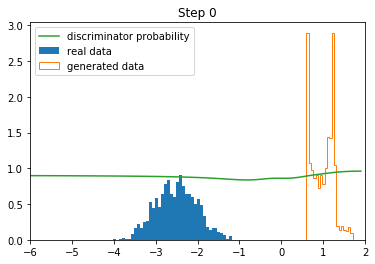

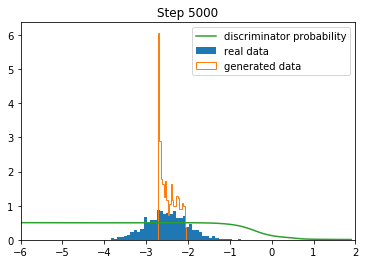

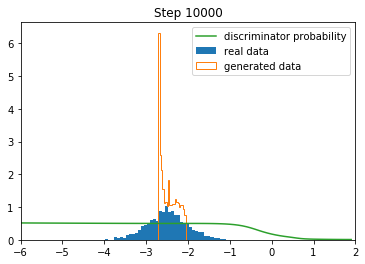

In [11]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)


for i in range(10001):
  z_batch = sample_z()
  x_batch = sample_x()
  sess.run(D_optimizer, feed_dict={z_p: z_batch, x_d: x_batch})
  z_batch = sample_z()
  sess.run(G_optimizer, feed_dict={z_p: z_batch})

  if i % 5000 == 0:
    print(f"[{datetime.now()}] Finished step {i}")
    show_histograms(f'Step {i}')

## Попробую более ранние шаги посмотреть

[2020-01-19 16:28:21.598301] Finished step 0
[2020-01-19 16:28:21.672808] Finished step 10
[2020-01-19 16:28:21.725449] Finished step 20
[2020-01-19 16:28:21.775916] Finished step 30
[2020-01-19 16:28:21.838170] Finished step 40
[2020-01-19 16:28:21.892516] Finished step 50
[2020-01-19 16:28:21.947198] Finished step 60
[2020-01-19 16:28:21.998479] Finished step 70
[2020-01-19 16:28:22.054148] Finished step 80
[2020-01-19 16:28:22.118470] Finished step 90
[2020-01-19 16:28:22.183354] Finished step 100


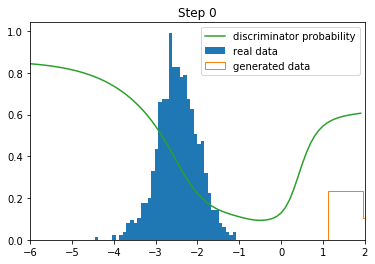

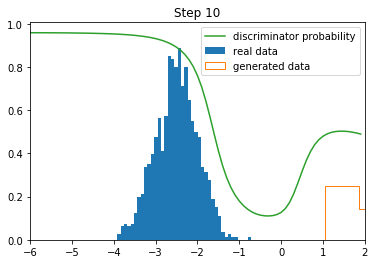

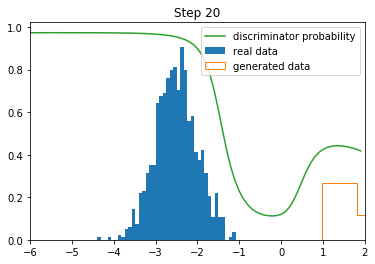

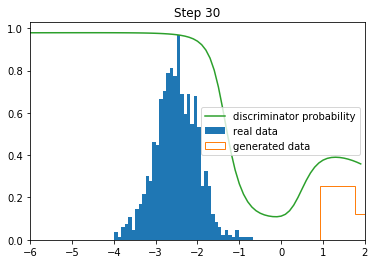

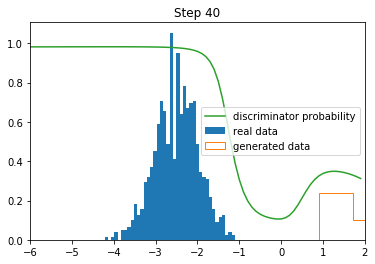

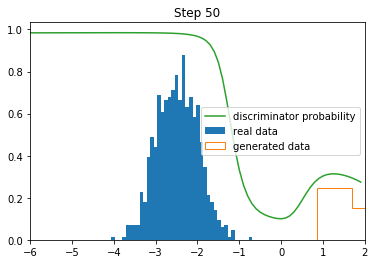

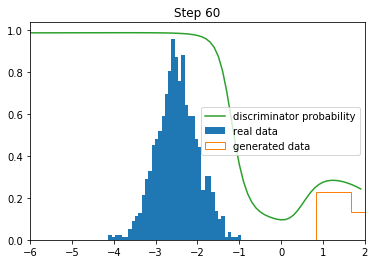

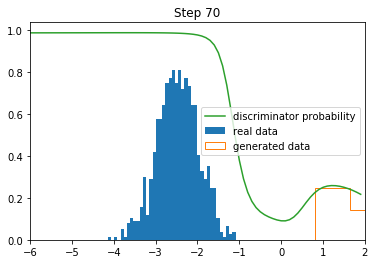

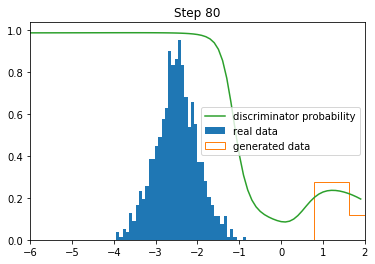

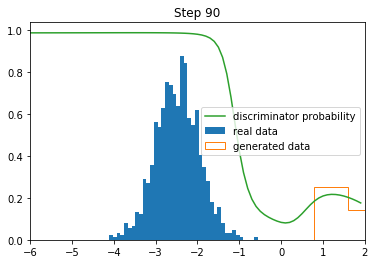

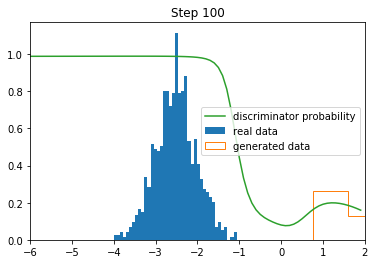

In [12]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)


for i in range(101):
  z_batch = sample_z()
  x_batch = sample_x()
  sess.run(D_optimizer, feed_dict={z_p: z_batch, x_d: x_batch})
  z_batch = sample_z()
  sess.run(G_optimizer, feed_dict={z_p: z_batch})

  if i % 10 == 0:
    print(f"[{datetime.now()}] Finished step {i}")
    show_histograms(f'Step {i}')

## Посмотрю на лоссы

[2020-01-19 16:28:25.091297] Finished step 0, D_cost=1.44899321, G_cost=-1.16079104
[2020-01-19 16:28:26.436866] Finished step 1000, D_cost=1.38559258, G_cost=-0.69144487
[2020-01-19 16:28:27.719428] Finished step 2000, D_cost=1.37080598, G_cost=-0.66416013
[2020-01-19 16:28:29.018228] Finished step 3000, D_cost=1.40463126, G_cost=-0.75937533
[2020-01-19 16:28:30.338402] Finished step 4000, D_cost=1.36516511, G_cost=-0.69889033
[2020-01-19 16:28:31.732153] Finished step 5000, D_cost=1.38989425, G_cost=-0.70399874
[2020-01-19 16:28:33.058880] Finished step 6000, D_cost=1.41170084, G_cost=-0.71902722
[2020-01-19 16:28:34.428405] Finished step 7000, D_cost=1.38422656, G_cost=-0.69658291
[2020-01-19 16:28:35.771875] Finished step 8000, D_cost=1.38733232, G_cost=-0.69588447
[2020-01-19 16:28:37.146584] Finished step 9000, D_cost=1.38648367, G_cost=-0.69392747
[2020-01-19 16:28:38.516561] Finished step 10000, D_cost=1.38151181, G_cost=-0.67778826


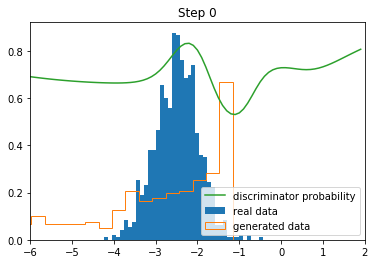

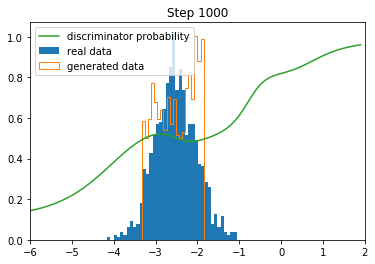

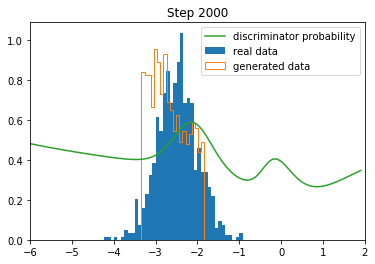

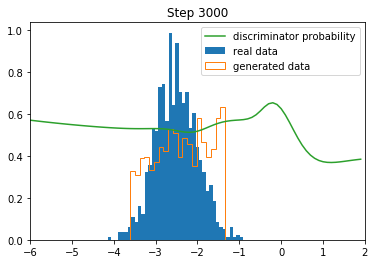

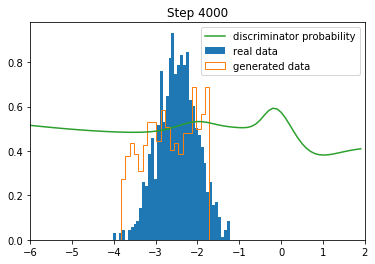

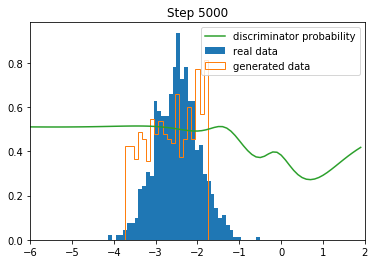

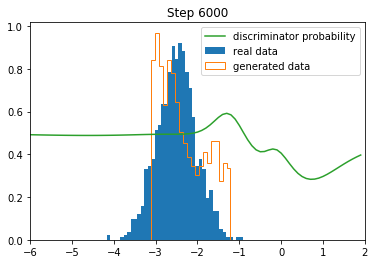

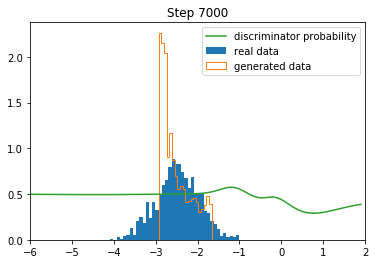

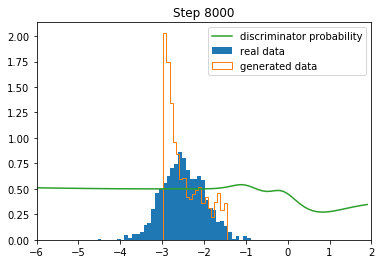

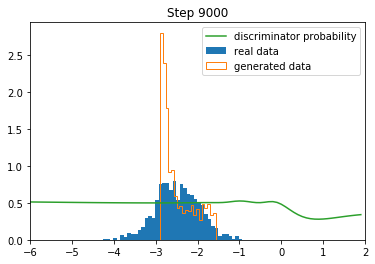

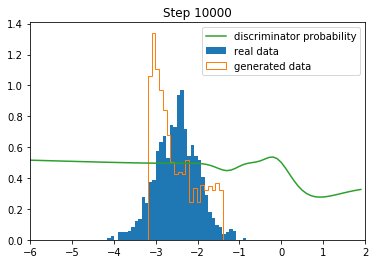

In [13]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)


for i in range(10001):
  z_batch = sample_z()
  x_batch = sample_x()
  sess.run(D_optimizer, feed_dict={z_p: z_batch, x_d: x_batch})
  z_batch = sample_z()
  sess.run(G_optimizer, feed_dict={z_p: z_batch})

  if i % 1000 == 0:
    d_val = sess.run(D_cost, feed_dict={z_p: z_batch, x_d: x_batch})
    g_val = sess.run(G_cost, feed_dict={z_p: z_batch})
    print(f"[{datetime.now()}] Finished step {i}, D_cost={d_val:.8f}, G_cost={g_val:.8f}")
    show_histograms(f'Step {i}')
    

## Качество не улучшается. Попробую другой learning rate

[2020-01-19 16:29:21.747556] Finished step 0, D_cost=0.00739030, G_cost=-0.00044800
[2020-01-19 16:29:23.154874] Finished step 1000, D_cost=0.00009928, G_cost=-0.00003459
[2020-01-19 16:29:24.516372] Finished step 2000, D_cost=0.00005222, G_cost=-0.00001952
[2020-01-19 16:29:25.865405] Finished step 3000, D_cost=0.00003549, G_cost=-0.00001372
[2020-01-19 16:29:27.145705] Finished step 4000, D_cost=0.00002691, G_cost=-0.00001065
[2020-01-19 16:29:28.469495] Finished step 5000, D_cost=0.00002169, G_cost=-0.00000875
[2020-01-19 16:29:29.776367] Finished step 6000, D_cost=0.00001816, G_cost=-0.00000741
[2020-01-19 16:29:31.150211] Finished step 7000, D_cost=0.00001560, G_cost=-0.00000644
[2020-01-19 16:29:32.510006] Finished step 8000, D_cost=0.00001370, G_cost=-0.00000569
[2020-01-19 16:29:33.882496] Finished step 9000, D_cost=0.00001237, G_cost=-0.00000512
[2020-01-19 16:29:35.205576] Finished step 10000, D_cost=0.00001109, G_cost=-0.00000464


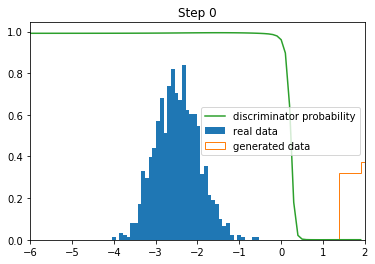

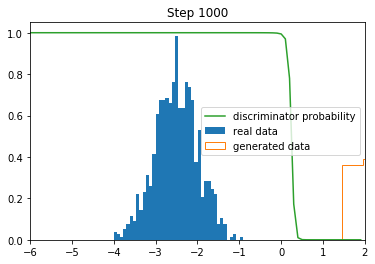

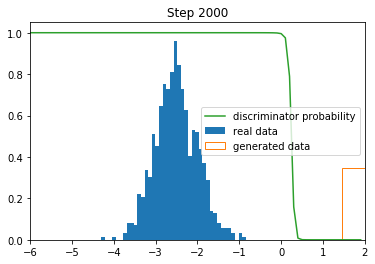

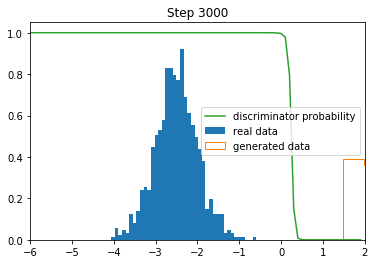

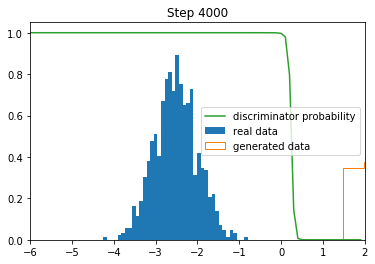

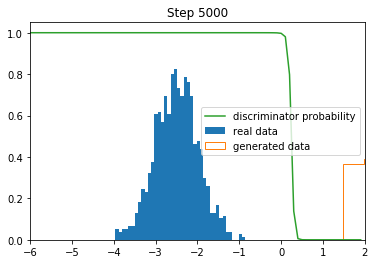

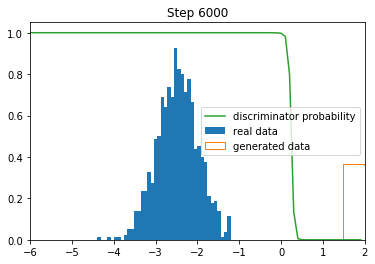

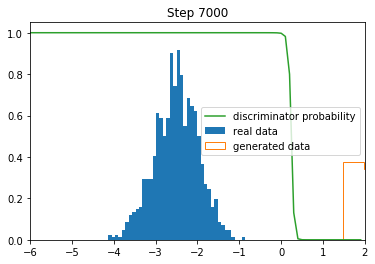

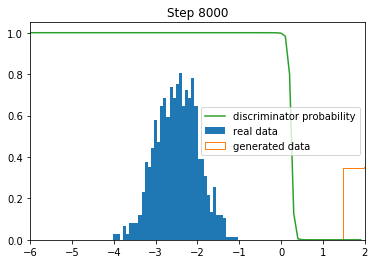

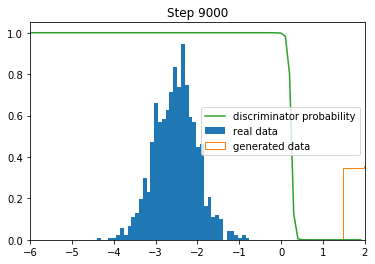

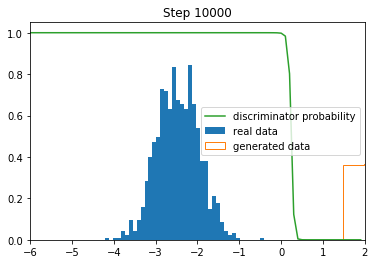

In [15]:
# был 0.01, пробовала 0.001, 0.0001, 0.00001, 0.1
learning_rate = 1

# оптимизаторы (к минимуму)
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
D_optimizer = optimizer.minimize(D_cost, var_list=disc_weights.values())
G_optimizer = optimizer.minimize(G_cost, var_list=gen_weights.values())

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)


for i in range(10001):
  z_batch = sample_z()
  x_batch = sample_x()
  sess.run(D_optimizer, feed_dict={z_p: z_batch, x_d: x_batch})
  z_batch = sample_z()
  sess.run(G_optimizer, feed_dict={z_p: z_batch})

  if i % 1000 == 0:
    d_val = sess.run(D_cost, feed_dict={z_p: z_batch, x_d: x_batch})
    g_val = sess.run(G_cost, feed_dict={z_p: z_batch})
    print(f"[{datetime.now()}] Finished step {i}, D_cost={d_val:.8f}, G_cost={g_val:.8f}")
    show_histograms(f'Step {i}')
    

# Применяю хаки из книги

In [0]:
def discriminator_hack(x):
  d_h1 = tf.nn.tanh(
    tf.add(
      tf.matmul(x, disc_weights['w1']), 
      disc_weights['b1']
    )
  )
  d_h2 = tf.nn.tanh(
    tf.add(
      tf.matmul(d_h1, disc_weights['w2']),
      disc_weights['b2']
    )
  )
  logits = tf.add(
    tf.matmul(d_h2, disc_weights['w3']),
    disc_weights['b3']
  )
  return logits

# применяем к разным типам данных
x_data_score = discriminator_hack(x_d)
x_gen_score = discriminator_hack(x_g)

# функции потерь
D_plus_cost = tf.reduce_mean(
  tf.nn.relu(x_data_score) - x_data_score +
  tf.log(1.0 + tf.exp(-tf.abs(x_data_score)))
)
D_minus_cost = tf.reduce_mean(
  tf.nn.relu(x_gen_score) +
  tf.log(1.0 + tf.exp(-tf.abs(x_gen_score)))
)
G_cost = tf.reduce_mean(
  tf.nn.relu(x_gen_score) - x_gen_score +
  tf.log(1.0 + tf.exp(-tf.abs(x_gen_score)))
)
D_cost = D_plus_cost + D_minus_cost

In [0]:
batch_size = 64
updates = 40000
learning_rate = 0.01

In [0]:
# оптимизаторы (к минимуму)
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
D_optimizer = optimizer.minimize(D_cost, var_list=disc_weights.values())
G_optimizer = optimizer.minimize(G_cost, var_list=gen_weights.values())

[2020-01-19 16:34:54.734205] Finished step 0, D_cost=4.94368601, G_cost=0.02926321
[2020-01-19 16:34:56.119680] Finished step 1000, D_cost=1.08857822, G_cost=1.60427165
[2020-01-19 16:34:57.447257] Finished step 2000, D_cost=1.27224898, G_cost=1.26317954
[2020-01-19 16:34:58.816190] Finished step 3000, D_cost=1.38151813, G_cost=0.70104855
[2020-01-19 16:35:00.205164] Finished step 4000, D_cost=1.39245486, G_cost=0.69230950
[2020-01-19 16:35:01.515858] Finished step 5000, D_cost=1.38651633, G_cost=0.69202292
[2020-01-19 16:35:02.834263] Finished step 6000, D_cost=1.38352799, G_cost=0.69111246
[2020-01-19 16:35:04.191032] Finished step 7000, D_cost=1.38876641, G_cost=0.69250602
[2020-01-19 16:35:05.521486] Finished step 8000, D_cost=1.38692796, G_cost=0.69806218
[2020-01-19 16:35:06.834102] Finished step 9000, D_cost=1.38740706, G_cost=0.69255173
[2020-01-19 16:35:08.170610] Finished step 10000, D_cost=1.38668704, G_cost=0.69470978


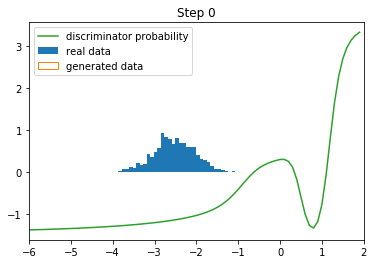

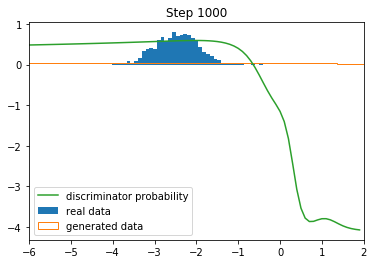

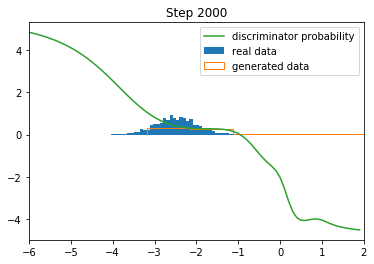

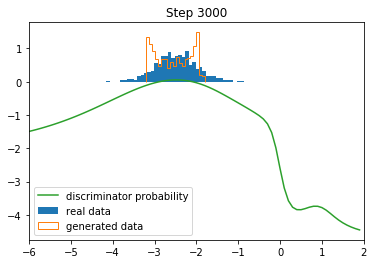

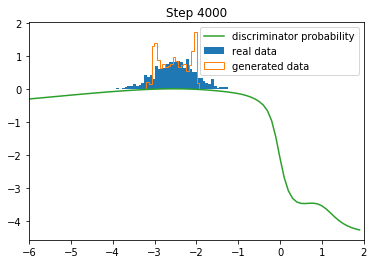

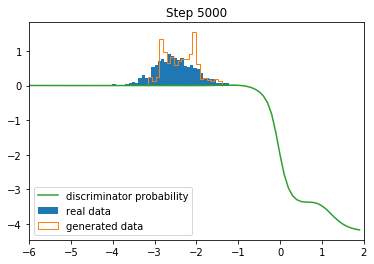

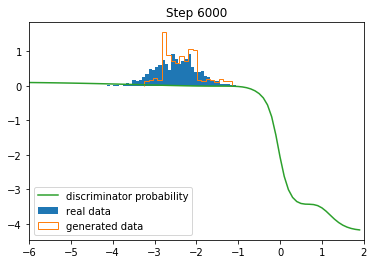

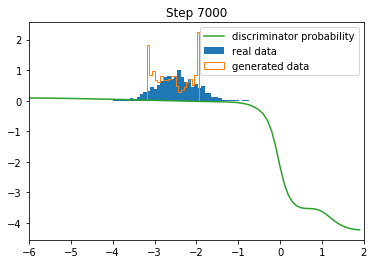

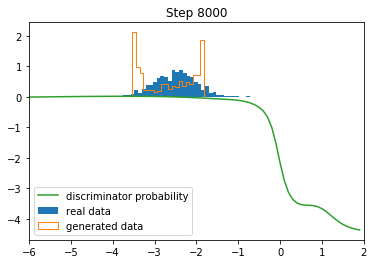

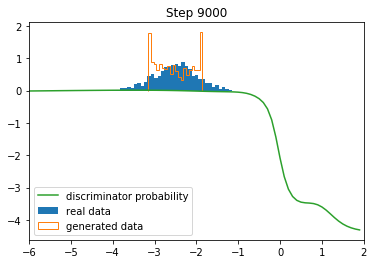

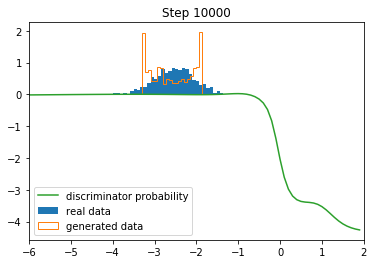

In [19]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)


for i in range(10001):
  z_batch = sample_z()
  x_batch = sample_x()
  sess.run(D_optimizer, feed_dict={z_p: z_batch, x_d: x_batch})
  z_batch = sample_z()
  sess.run(G_optimizer, feed_dict={z_p: z_batch})

  if i % 1000 == 0:
    d_val = sess.run(D_cost, feed_dict={z_p: z_batch, x_d: x_batch})
    g_val = sess.run(G_cost, feed_dict={z_p: z_batch})
    print(f"[{datetime.now()}] Finished step {i}, D_cost={d_val:.8f}, G_cost={g_val:.8f}")
    show_histograms(f'Step {i}')

# Отрицательные вероятности, неплохо

Выглядит как замки на холме